In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from cplAE_TE.utils.load_helpers import get_paths, load_dataset, load_htree_well_sampled
from cplAE_TE.utils.tree_helpers import HTree

%matplotlib inline

In [2]:
path = get_paths(warn=False,write_toml=False)

Only searching through inhibitory taxonomy (n59)
53 cell types retained, with at least 10 samples in the dataset


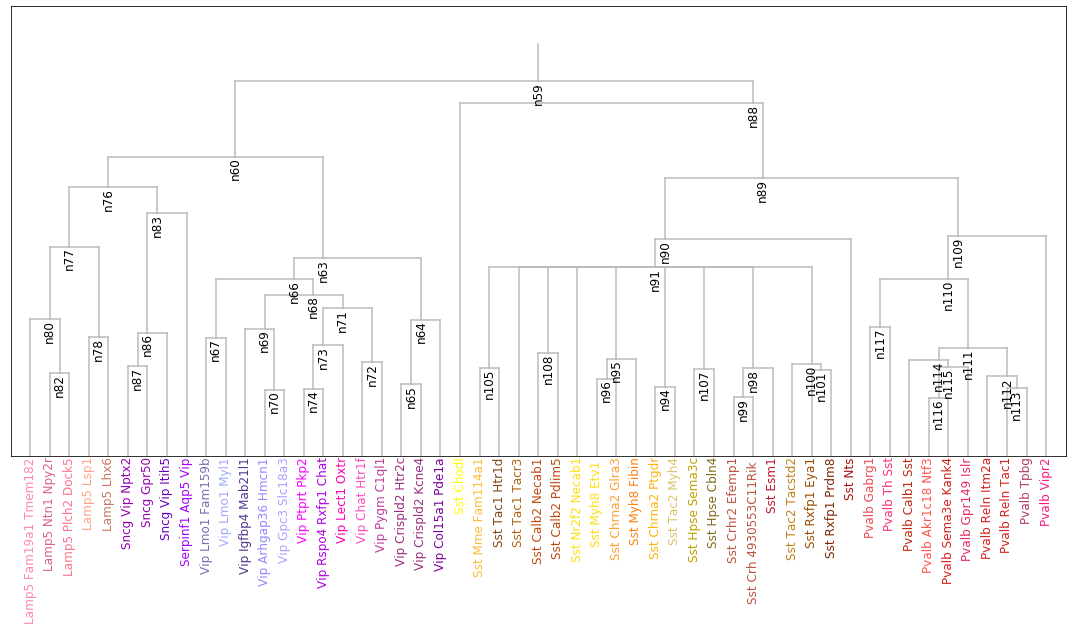

In [3]:
htree = load_htree_well_sampled(min_sample_thr=10, simplify=True)
df = htree.obj2df()
htree.plot((15, 8), fontsize=12)
plt.show()

In [4]:
from cplAE_TE.utils.tree_helpers import Node, get_valid_partitions
from timebudget import timebudget
from tqdm import tqdm

The transcriptomic taxonomy is resolved to very fine detail (53 classes here). Moreover the different heights at which the hierarchy is split is based on transcriptomic data alone (i.e. resolution index, see `Tasic et al. 2018`). 

One can obtain a smaller number of classes by performing a horizontal cut on the hierarchical tree, but this could be sensitive to the specific similarity measure used to construct the hierarchical tree. We therefore want to allow for some ambiguity in how a smaller set of classes may be obtained, while largely respecting the transcriptomic partitioning at the class level. 

Here, merging is performed only for children of nodes defined in `start_node_name_list`. The intuition is that some types/ cell classes are salient, and these cell classes should always be present in all the partitions being considered. This will also allow us to reduce the number of partitions we consider for any downstream task.

Below we perform this classification separately for the `n88` and `n60` internal nodes of the taxonomy, and use the combinations to come up with _valid_ n-way partitions.

In [5]:
start_node_name_list = {}
start_node_name_list['n88'] = htree.child[htree.parent=='n91'].tolist() + ['Sst Chodl','Sst Nts'] + \
                            ['n117'] + htree.child[htree.parent=='n111'].tolist() + ['Pvalb Vipr2']

start_node_name_list['n60'] = htree.child[htree.parent=='n76'].tolist() + htree.child[htree.parent=='n63'].tolist()

with timebudget('Calculate valid partitions'):
    valid_partitions = {}
    for n in ['n60','n88']:
        print(f'Subtree with root node: {n}')
        subtree = htree.get_subtree(node=n)
        start_node_list = [Node(name=nn,C_list=subtree.child,P_list=subtree.parent) for nn in start_node_name_list[n]]
        valid_partitions[n]=[]
        valid_partitions[n] = get_valid_partitions(start_node_list,
                                                        C_list=subtree.child,
                                                        P_list=subtree.parent,
                                                        valid_partitions=valid_partitions[n])

    for n in ['n60','n88']:
        valid_partitions[n].sort(key=len)
        hist_counts = pd.Series([len(classification) for classification in valid_partitions[n]]).value_counts().to_frame()
        hist_counts.reset_index(inplace=True)
        hist_counts = hist_counts.rename(columns={'index':'n_classes',0:'classifications'}).sort_values(by='n_classes').reset_index(drop=True)

        print(hist_counts.to_string())
        print('Total: {:d} \n'.format(len(valid_partitions[n])))

Subtree with root node: n60
Subtree with root node: n88
    n_classes  classifications
0           4                1
1           5                4
2           6               12
3           7               28
4           8               57
5           9              105
6          10              178
7          11              278
8          12              394
9          13              500
10         14              560
11         15              547
12         16              460
13         17              328
14         18              194
15         19               92
16         20               33
17         21                8
18         22                1
Total: 3780 

    n_classes  classifications
0          15                1
1          16               10
2          17               50
3          18              166
4          19              409
5          20              792
6          21             1246
7          22             1624
8          23             1772


Found 14 unique ways of obtaining 20-way partitions


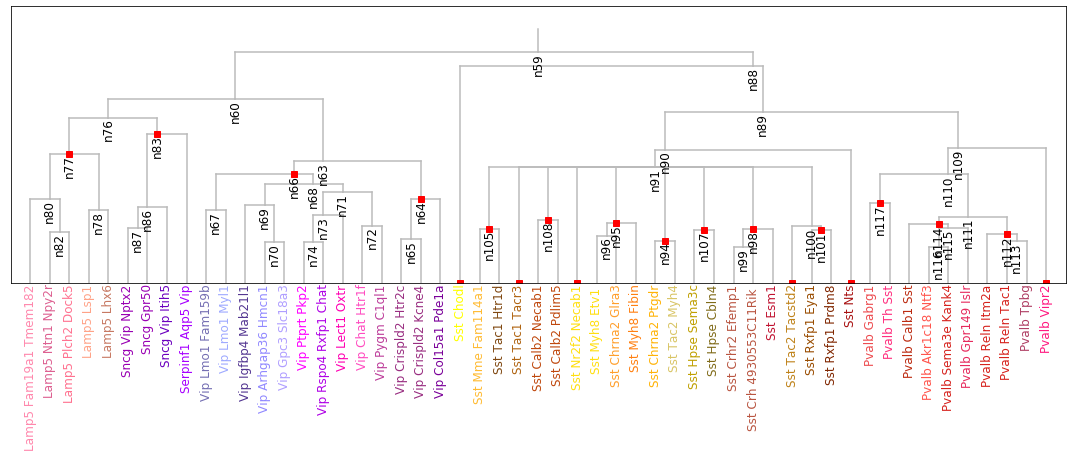

In [6]:
#Find all valid ways of merging the taxonomy to obtain "n"
n = 20
n_way_partitions = []
for i in valid_partitions['n60']:
    for j in valid_partitions['n88']:
        if len(i)+len(j)==n:
            n_way_partitions.append(i+j)    
print(f'Found {len(n_way_partitions)} unique ways of obtaining {n}-way partitions')

#Plot an example - red nodes indicate the `n` partitions
htree.plot((15,5),fontsize=12)
htree.plotnodes(n_way_partitions[0])
plt.show()